앙상블
```
배깅(Bagging)
데이터를 무작위로 뽑아서(부트스트랩) 여러모델(결정트리)을 만들고 결과를 평균(회귀) 다수결(분류)로 합치는 방법
대표모델 : RandomForest
T : 모델개수
ht(x) : t번째 모델 예측
```
$$\hat{y} = \frac{1}{T} \sum_{t=1}^{T} h_t(x)$$

```
부스팅(Boosting)
여러개의 학습기를 순차적으로 학습시키면서 이전모델의 오차를 줄이는 방식
Gradient Boosting, AdaBoost, XGBoost
```
```
스태킹
여러개의 모델이 예측한 값들을 다시 메타모델이 학습
ex) 로지스틱 회귀
```
$$\hat{y} = g(h_1(x), h_2(x), \dots, h_T(x))$$

```
투표(Voting)
소프트 보팅 : 확률 평균으로 결정
하드 보팅 : 다수결
```

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')
# 결측치 제거
df.dropna(inplace=True)
X = df.drop(columns=['PassengerId','Survived'])
y = df['Survived']
X = X.select_dtypes(exclude='object')
ss = StandardScaler()
X = ss.fit_transform(X)

# z-score 방식으로 이상치 제거
import seaborn as sns
# sns.boxplot(data=df, x='Fare')
from scipy.stats import zscore
temp = zscore(df['Fare'])
df = df[(temp > -3) & (temp < 3)]

X = df.drop(columns=['PassengerId','Survived'])
y = df['Survived']
X = X.select_dtypes(exclude='object')
# 연속형데이터를 범주형으로 벼경
X['Age'] = pd.cut(X['Age'],bins=3,labels=[0,1,2])
X['Family_count'] = X['SibSp'] + X['Parch'] + 1
X.drop(columns=['SibSp','Parch'],inplace=True)
X['Fare'] = pd.cut(X['Fare'],bins=3,labels=[0,1,2])
# 원핫
X = pd.concat([X,pd.get_dummies(df['Sex']).astype(int)], axis=1)
X = pd.concat([X,pd.get_dummies(df['Embarked']).astype(int)], axis=1)

X['IsCabin'] = df['Cabin'].notnull().astype(int)
ss = StandardScaler()
X = ss.fit_transform(X)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')
df.drop(['Cabin'],axis=1,inplace=True)
df['Age'] = df['Age'].fillna(float(df['Age'].mean()))


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])
df = df.select_dtypes(include='number')
X = df.drop(['Survived'], axis=1)
y = df.iloc[:,1]
X = ss.fit_transform(X)
rf = RandomForestClassifier()
for model in [rf]:
  sk = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)
  scores = cross_validate(model,X,y,cv=sk)
  print(model.__class__.__name__,np.mean(scores['test_score']))

RandomForestClassifier 0.827154604230745


In [ ]:
# 배깅
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier,VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from xgboost import XGBClassifier
import numpy as np

kfold = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)
rfc = RandomForestClassifier(random_state=42,n_estimators=100,max_depth=3)
rfc.fit(X,y)
scores = cross_validate(rfc, X, y, cv=kfold, return_estimator=True)
print(np.mean(scores['test_score']))

#부스팅
abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),random_state=42,n_estimators=100)
scores = cross_validate(abc, X, y, cv=kfold, return_estimator=True)
print(np.mean(scores['test_score']))
# 그래디언트 부스팅
gb = GradientBoostingClassifier(random_state=42,n_estimators=100,max_depth=3)
scores = cross_validate(gb, X, y, cv=kfold, return_estimator=True)
print(np.mean(scores['test_score']))
# XGBoost
xgb = XGBClassifier(random_state=42,n_estimators=100,max_depth=3)
scores = cross_validate(xgb, X, y, cv=kfold, return_estimator=True)
print(np.mean(scores['test_score']))
# 스태킹
from sklearn.neighbors import KNeighborsClassifier
estimators = [
    ('rf',RandomForestClassifier(n_estimators=100,max_depth=3,random_state=42)),
    ('xgb',XGBClassifier(n_estimators=100,max_depth=3,random_state=42)),
    ('knn',KNeighborsClassifier())   ,
    ('ada',AdaBoostClassifier(n_estimators=100,random_state=42)),
    ('db',GradientBoostingClassifier(n_estimators=100,max_depth=3,random_state=42)),
]
metamodel = VotingClassifier(estimators=estimators,voting='soft')
metamodel.fit(X,y)
scores = cross_validate(metamodel, X, y, cv=kfold, return_estimator=True)
print(np.mean(scores['test_score']))


# 실제 구현
from sklearn.linear_model import LogisticRegression
metamodel = RandomForestClassifier(random_state=42)
# 1. 개별모델의 예측 생성(교차검증이용)
kf = StratifiedKFold(n_splits=5, shuffle=True)
train_meta_features = np.zeros((X.shape[0],len(estimators))) # 메타데이터 특성
from sklearn.model_selection import cross_val_predict
for i,(name,model) in enumerate(estimators):
  train_meta_features[:,i] =  cross_val_predict(model,X,y,cv=kf)
# 2. 메타모델 학습
metamodel.fit(train_meta_features,y)
# 3. 최종 예측
scores = cross_validate(metamodel, train_meta_features, y, cv=kfold, return_estimator=True)
print(np.mean(scores['test_score']))

0.8148138848785388
0.8125792480070304
0.8260059004456719
0.821542903772519
0.8282593685267716
0.8226476680685456


서포트 벡터 머신
```
SVM : 두 클래스(사망/생존)을 나누는 선을 찾음
이 선이 클래스 사이의 간격(마진)을 최대한 크게 만드는 목표
결정경계 : 두 클래스를 나누는선 또는 평면
마진 : 결정경계와 가장 가까운 데이터 포인트(Support Vector)  사이의 거리가 클수록 안정적인 모델
```

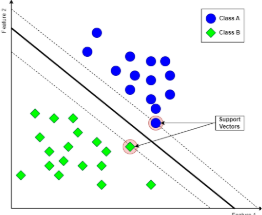

In [ ]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')

scores = cross_validate(svc, X, y, cv=kfold, return_estimator=True)
print(np.mean(scores['test_score']))

0.7867553825874082


In [ ]:
!wget https://bit.ly/fruits_300_data -O fruits_300.npy

--2025-03-28 01:38:38--  https://bit.ly/fruits_300_data
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/rickiepark/hg-mldl/raw/master/fruits_300.npy [following]
--2025-03-28 01:38:38--  https://github.com/rickiepark/hg-mldl/raw/master/fruits_300.npy
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/hg-mldl/master/fruits_300.npy [following]
--2025-03-28 01:38:39--  https://raw.githubusercontent.com/rickiepark/hg-mldl/master/fruits_300.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... conne

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fruits = np.load('fruits_300.npy')
print(fruits.shape)

(300, 100, 100)


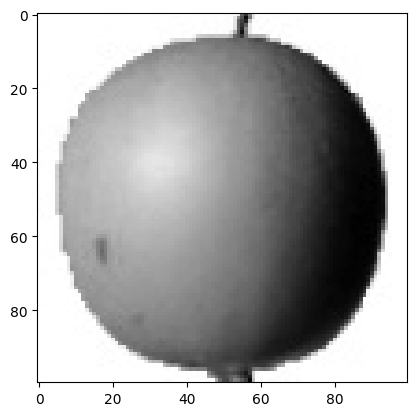

In [ ]:
plt.imshow(fruits[0], cmap='gray_r')
plt.show()

In [ ]:
apple = fruits[0:100].reshape(-1, 100*100)
pineapple = fruits[100:200].reshape(-1, 100*100)
banana = fruits[200:300].reshape(-1, 100*100)

In [ ]:
print(apple.shape, pineapple.shape, banana.shape)

(100, 10000) (100, 10000) (100, 10000)


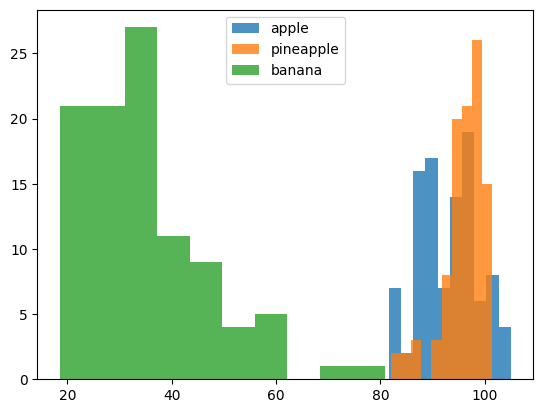

In [ ]:
plt.hist(np.mean(apple, axis=1), alpha=0.8)
plt.hist(np.mean(pineapple, axis=1), alpha=0.8)
plt.hist(np.mean(banana, axis=1), alpha=0.8)
plt.legend(['apple', 'pineapple', 'banana'])
plt.show()

k-means k평균
```
데이터를 비슷한 특징으로 가진그룹(클러스터)로 나누는 비지도 학습법
목적함수
각 데이터포인트가 자신이 속한 클러스터의 중심점까지의 거리 제곱의 총합 , 값이 작을수도록 잘 모여있다
```
$$J = \sum_{i=1}^{n} \sum_{k=1}^{K} r_{ik} ||x_i - \mu_k||^2$$

```
중심점 업데이트
```
$$\mu_k = \frac{\sum_{i=1}^{n} r_{ik} x_i}{\sum_{i=1}^{n} r_{ik}}$$


In [ ]:
print(fruits.shape)
fruits_2d = fruits.reshape(-1,100*100)

(300, 100, 100)


In [ ]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4, random_state=42)
km.fit(fruits_2d)
print(km.labels_)

[2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 0 2 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 0 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 3 3 3 3 1 3 1 1 3 3 3 3 1 1 1 1 3 1 1
 3 3 3 3 3 3 3 1 3 3 3 1 3 1 3 3 3 3 1 1 3 3 3 1 3 3 3 1 3 3 3 1 3 3 3 3 1
 3 3 3 1 3 3 3 3 1 3 3 3 1 1 0 3 3 3 1 1 3 3 3 1 3 3 3 3 1 1 3 3 3 3 1 1 1
 1 3 1 3]


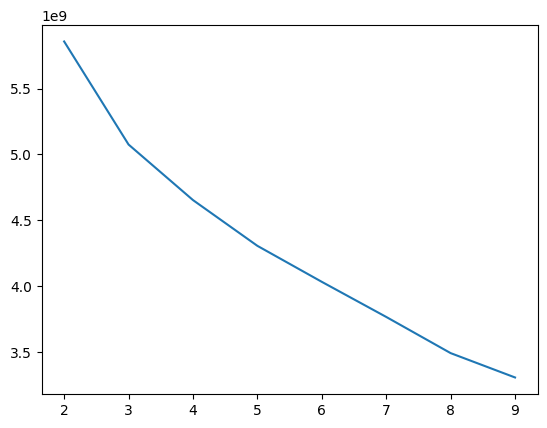

In [ ]:
temp = []
for k in range(2,10):
  kn = KMeans(n_clusters=k, random_state=42)
  kn.fit(fruits_2d)
  temp.append(kn.inertia_)  # inertia_ 목적함수의 값
plt.plot(range(2,10),temp)
plt.show()

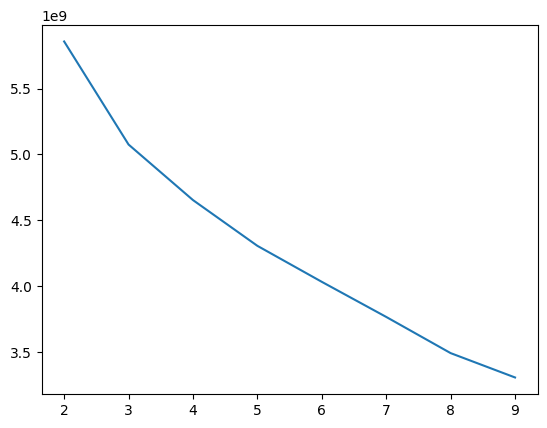

In [ ]:
# 타이타닉 적용 - 군집
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')
temp = []
for k in range(2,10):
  kn = KMeans(n_clusters=k, random_state=42)
  kn.fit(fruits_2d)
  temp.append(kn.inertia_)  # inertia_ 목적함수의 값
plt.plot(range(2,10),temp)
plt.show()

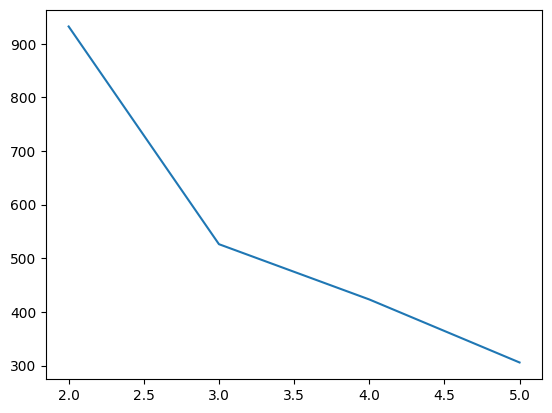

클러스터 중심점....
클러스터_1 : [0.06908524 3.16238949]
클러스터_2 : [-0.58445172 -0.30479836]
클러스터_3 : [ 1.06849506 -0.03063012]


In [ ]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
# 나이와 요금사이의 군집관계
# 1. 나이와 요금데이터만 추출
X = df[['Age','Fare']].copy()

# 2. 결측치와 이상치 처리
X.dropna(inplace=True)
X = X[X['Fare']<= 400]

# 3. 스케일링
ss = StandardScaler()
XX = ss.fit_transform(X)

inertia=[]
# 4. k-means 적용
for k in range(2,6):
  km = KMeans(n_clusters=k, random_state=42)
  km.fit(XX)
  inertia.append(km.inertia_)  # inertia_ 목적함수의 값
plt.plot(range(2,6), inertia  )
plt.show()
# 5. 적합한 클러스터의 개수 확인 및 적용(엘보우)
km = KMeans(n_clusters=3, random_state=42)
km.fit(XX)
# 6. 클러스터의 중심점 출력 모델.cluster_centers_
print('클러스터 중심점....')
for idx, cluster_center in enumerate(km.cluster_centers_):
  print(f'클러스터_{idx+1} : {cluster_center}')

In [ ]:
ss.inverse_transform(km.cluster_centers_)

array([[ 30.68      , 168.39080909],
       [ 21.176097  ,  19.59897921],
       [ 45.21367521,  31.36470855]])

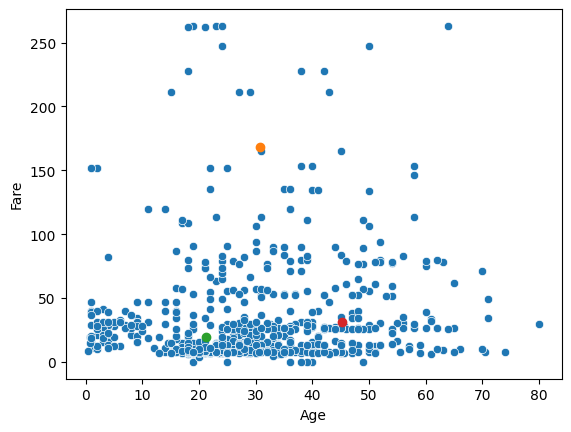

In [ ]:
sns.scatterplot(x = df['Age'], y=df[df['Fare']<=400]['Fare'])
plt.scatter(x=30.68, y = 168.39080909)
plt.scatter(x=21.176097, y=19.59897921)
plt.scatter(x=45.21367521, y=31.36470855)

# 이미지 분류  시스템 (클러스터링 )
# 이미그룹에서 같은 이미지만 분류해서 폴더도 자동생성
# 같은 이미지는 같은 폴더에 저장

In [ ]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits

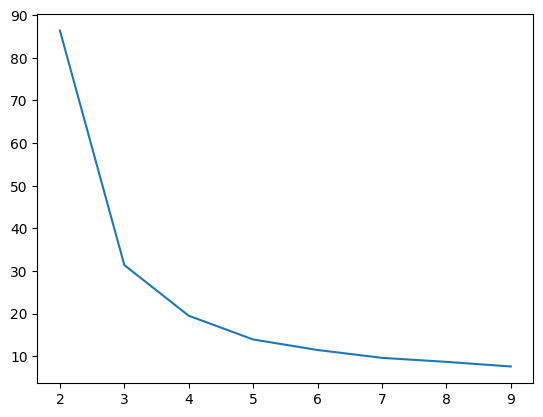

In [ ]:
iris = load_iris()
datas = iris.data[:,2:]
inertia=[]
for k in range(2,10):
  km = KMeans(n_clusters=k, random_state=42)
  km.fit(datas)
  inertia.append(km.inertia_)
plt.plot(range(2,10),inertia)
plt.show()

In [ ]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

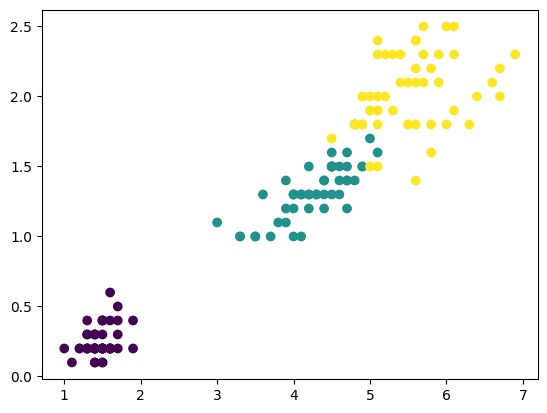

In [ ]:
plt.scatter(datas[:,0], datas[:,1],c=iris.target)
plt.show()

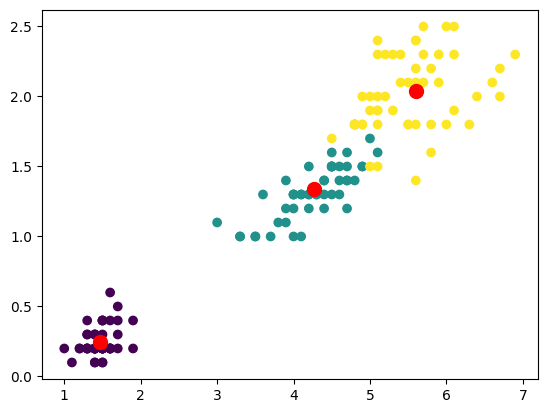

In [ ]:
km = KMeans(n_clusters=3, random_state=42)
km.fit(datas)
len(km.labels_)
plt.scatter(datas[:,0], datas[:,1],c=iris.target)
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], s=100, c='red')
plt.show()

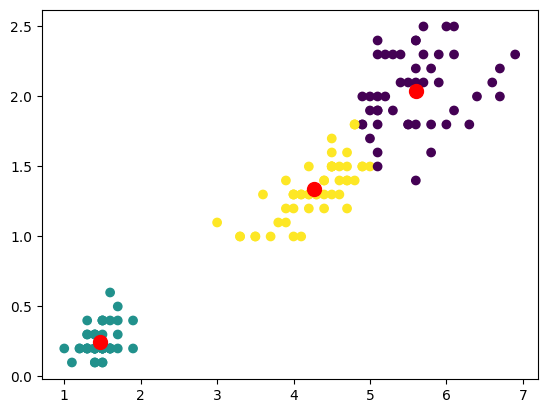

In [ ]:
km = KMeans(n_clusters=3, random_state=42)
km.fit(datas)
len(km.labels_)
plt.scatter(datas[:,0], datas[:,1],c=km.labels_)
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],s=100,c='red')
plt.show()

```
이미지를 분류 군집 분석
  1. 데이터(실제 이미지)
  2. 크기가 다양함 -> 동일한 사이즈로 조정
  3. 이미지를 넘파이로 변환
  4. 군집분석에 적용
```

In [ ]:
df = load_digits()

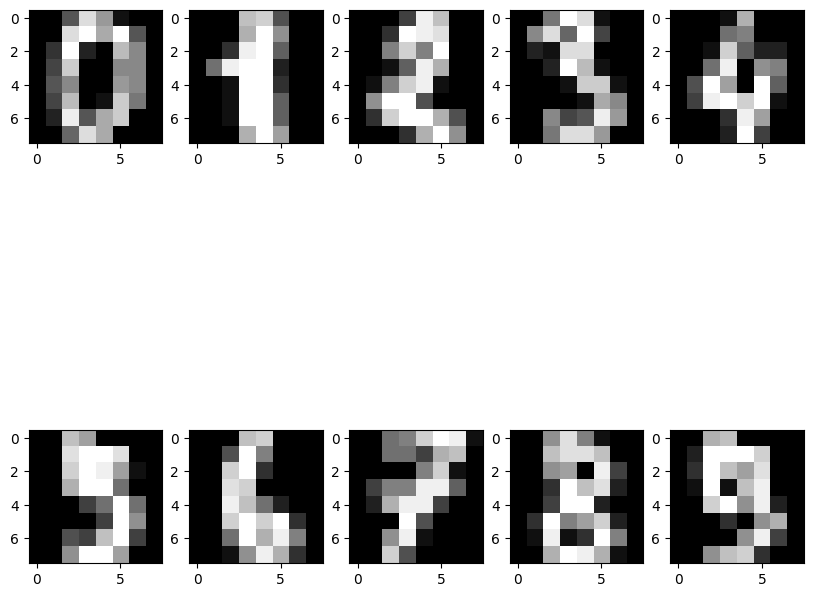

In [ ]:
plt.figure(figsize=(10,10))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(df.images[i], cmap='gray')

In [ ]:
df.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [ ]:
X = df['data']
y = df['target']
X.shape, y.shape

((1797, 64), (1797,))

In [ ]:
Xs = ss.fit_transform(X)
Xs.shape

(1797, 64)

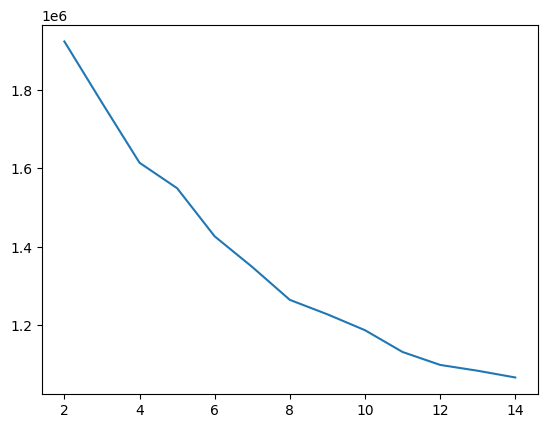

In [ ]:
inertia = []
for k in range(2,15):
  km = KMeans(n_clusters=k, random_state=42)
  km.fit(X)
  inertia.append(km.inertia_)  # inertia_ 목적함수의 값


plt.plot(range(2,15), inertia)
plt.show()

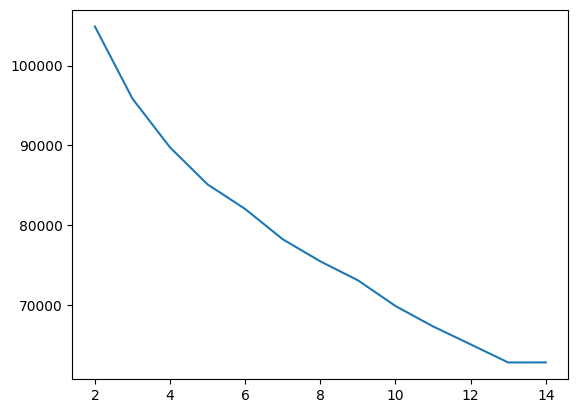

In [ ]:
inertia = []
for k in range(2,15):
  km = KMeans(n_clusters=k, random_state=42)
  km.fit(Xs)
  inertia.append(km.inertia_)  # inertia_ 목적함수의 값


plt.plot(range(2,15), inertia)
plt.show()

In [ ]:
km = KMeans(n_clusters=13, random_state=42)
km.fit(Xs)
km.inertia_

62763.180753616325

In [ ]:
# 클러스터의 개수는 4 or 8
km = KMeans(n_clusters=4, random_state=42)
km.fit(X)
np.unique(km.labels_, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([345, 600, 490, 362]))

In [ ]:
class_0 = X[km.labels_ == 3]
class_1 = X[km.labels_ == 3]
class_2 = X[km.labels_ == 3]
class_3 = X[km.labels_ == 3]


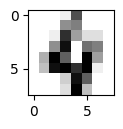

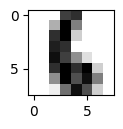

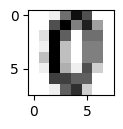

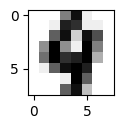

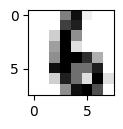

In [ ]:
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(class_0[i].reshape(8,8), cmap='gray_r')
  plt.show()

In [ ]:
!unzip /content/drive/MyDrive/data/img/horse-or-human.zip -d data/

unzip:  cannot find or open /content/drive/MyDrive/data/img/horse-or-human.zip, /content/drive/MyDrive/data/img/horse-or-human.zip.zip or /content/drive/MyDrive/data/img/horse-or-human.zip.ZIP.


In [ ]:
from glob import glob
files = glob('/content/drive/MyDrive/data/dogcat/**/*.jpg',recursive=True)
print('총 파일개수',len(files))

총 파일개수 800


In [ ]:
!pip install opencv-python

In [ ]:
import cv2
img = cv2.imread(files[799])  # 이미지 읽기(수치화)
img = cv2.resize(img,(64,64)) # 사이즈 조정
img = img.flatten()  # (12288,)   # 데이터 평탄화

In [ ]:
img

array([ 62,  93, 124, ...,  68,  92,  92], dtype=uint8)

In [ ]:
from tqdm import tqdm
images = []
for file in tqdm(files):
  img = cv2.imread(file)
  img = cv2.resize(img,(64,64))
  img = img.flatten()/255.0
  images.append(img)

100%|██████████| 800/800 [03:50<00:00,  3.47it/s]


In [ ]:
images = np.array(images)
km = KMeans(n_clusters=2, random_state=42)
km.fit(images)

KMeans(n_clusters=2, random_state=42)

In [ ]:
km.labels_[:3], files[:3]

(array([0, 1, 1], dtype=int32),
 ['/content/drive/MyDrive/data/dogcat/cat/cat.1031.jpg',
  '/content/drive/MyDrive/data/dogcat/cat/cat.1029.jpg',
  '/content/drive/MyDrive/data/dogcat/cat/cat.1019.jpg'])

In [ ]:
!mkdir cat

In [ ]:
!mkdir dog

In [ ]:
np.unique(km.labels_, return_counts=True)

(array([0, 1], dtype=int32), array([413, 387]))

In [ ]:
files = np.array(files)
len(files[km.labels_ == 0]), len(files[km.labels_ == 1])

(413, 387)

In [ ]:
# import shutil
# shutil.move(a,b)
# import os
# os.rename(a,b)
import shutil

for file in files[km.labels_ == 0]:
    shutil.move(file, 'cat/' + file.split('/')[-1])

for file in files[km.labels_ == 1]:
    shutil.move(file, 'dog/' + file.split('/')[-1])